In [1]:
from google.colab import drive

In [2]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import tensorflow as tf

print(tf.__version__)

2.9.2


In [4]:
#importing libraries
import numpy as np  # NUMPY
import pandas as pd # PANDAS
from PIL import Image, ImageFilter
import cv2
import os
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
from scipy.ndimage.filters import convolve
import seaborn as sns
from sklearn.metrics import classification_report

In [5]:
!pip install tflearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#PART A

In [7]:
#1. Import and Understand the data 
#A. Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python
images_path = "/content/gdrive/MyDrive/AIML/LABS/Computer Vision/plant-seedlings-classification.zip"

from zipfile import ZipFile
with ZipFile(images_path,'r') as zip:
  zip.extractall()

In [8]:
#B. Map the images from train folder with train labels to form a DataFrame
import os
import pandas as pd

# Define the path to the base folder that contains the label folders
base_folder = '/content/plant-seedlings-classification/train'

# Create an empty list to store the data
data = []

# Iterate through the label folders in the base folder
for label_folder in os.listdir(base_folder):
    label_folder_path = os.path.join(base_folder, label_folder)
    # Iterate through the files in the label folder
    for root, dirs, files in os.walk(base_folder):
       for file in files:
           file_path = os.path.join(root, file)
           label = os.path.basename(root)
           data.append([file, label, file_path])


# Create the DataFrame
df = pd.DataFrame(data, columns=['Name', 'Species', 'Image'])


In [9]:
df

,Name,Species,Image
0,.DS_Store,train,/content/plant-seedlings-classification/train/...
1,77686f343.png,Shepherds Purse,/content/plant-seedlings-classification/train/...
2,8f72e841a.png,Shepherds Purse,/content/plant-seedlings-classification/train/...
3,33ea3207a.png,Shepherds Purse,/content/plant-seedlings-classification/train/...
4,3a98ad207.png,Shepherds Purse,/content/plant-seedlings-classification/train/...
...,...,...,...
61758,d21bfbaa7.png,Small-flowered Cranesbill,/content/plant-seedlings-classification/train/...
61759,f43489876.png,Small-flowered Cranesbill,/content/plant-seedlings-classification/train/...
61760,5b7582e22.png,Small-flowered Cranesbill,/content/plant-seedlings-classification/train/...
61761,7405aee1b.png,Small-flowered Cranesbill,/content/plant-seedlings-classification/train/...


In [10]:
df.shape

(61763, 3)

In [11]:
df.dtypes

Name       object
Species    object
Image      object
dtype: object

In [12]:
df.sum()

Name       .DS_Store77686f343.png8f72e841a.png33ea3207a.p...
Species    trainShepherds PurseShepherds PurseShepherds P...
Image      /content/plant-seedlings-classification/train/...
dtype: object

In [13]:
#C. Write a function that will select n random images and display images along with its species.
import os
import cv2

dataset = '/content/plant-seedlings-classification/train'
X = []
Y = []
labels = []

# list all folders inside train directory
for i in os.listdir(dataset):
    print(i)
    if i!= '.DS_Store':   #Specific to Mac
      labels.append(i)        
      for j in os.listdir(os.path.join(dataset, i)):
        # read each image inside train directory one by one
        dummy = cv2.imread(os.path.join(dataset, i, j))
        dummy = cv2.resize(dummy, (128, 128))   # Resizing can be any number - 128 is just kept for standard reference
        X.append(dummy)
        Y.append(i)

Shepherds Purse
Sugar beet
Loose Silky-bent
Charlock
Maize
Common Chickweed
Common wheat
Fat Hen
Scentless Mayweed
.DS_Store
Cleavers
Black-grass
Small-flowered Cranesbill


[2227  995 3569 1249 3122]


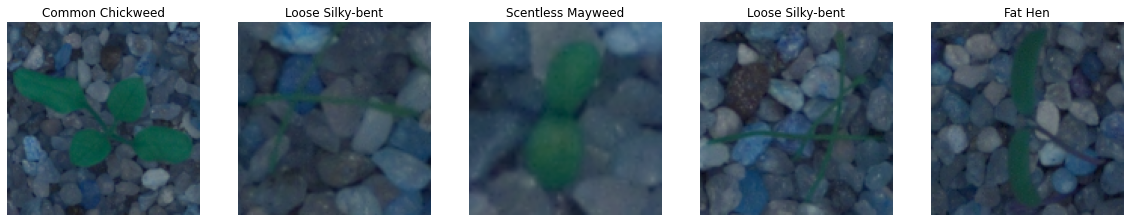

In [14]:
import matplotlib.pyplot as plt # MATPLOTLIB FOR PLOTTING
import numpy as np
rand = np.random.randint(0, len(X), 5) # Generating 10 random numbers out of total number of flowers
print(rand)
plt.figure(figsize=(20, 20))
for i,j in enumerate(rand):
    plt.subplot(1, len(rand), i+1)
    plt.imshow(X[j])  # greens, reds, blues, rgb
    plt.title("{}".format(Y[j]))
    plt.axis('off')
plt.show()

In [15]:
#2. Data preprocessing 
#A. Create X & Y from the DataFrame.
x = df.iloc[:, :-1]
y = df.iloc[:, -1]


In [16]:
x

,Name,Species
0,.DS_Store,train
1,77686f343.png,Shepherds Purse
2,8f72e841a.png,Shepherds Purse
3,33ea3207a.png,Shepherds Purse
4,3a98ad207.png,Shepherds Purse
...,...,...
61758,d21bfbaa7.png,Small-flowered Cranesbill
61759,f43489876.png,Small-flowered Cranesbill
61760,5b7582e22.png,Small-flowered Cranesbill
61761,7405aee1b.png,Small-flowered Cranesbill


In [17]:
y

0        /content/plant-seedlings-classification/train/...
1        /content/plant-seedlings-classification/train/...
2        /content/plant-seedlings-classification/train/...
3        /content/plant-seedlings-classification/train/...
4        /content/plant-seedlings-classification/train/...
                               ...                        
61758    /content/plant-seedlings-classification/train/...
61759    /content/plant-seedlings-classification/train/...
61760    /content/plant-seedlings-classification/train/...
61761    /content/plant-seedlings-classification/train/...
61762    /content/plant-seedlings-classification/train/...
Name: Image, Length: 61763, dtype: object

In [18]:
# import required libraries
import pandas as pd
import numpy as np
# creating initial dataframe
Species_types = ('Shepherds Purse','Sugar beet','Loose Silky-bent','Charlock','Maize','Common Chickweed','Common wheat','Fat Hen','Scentless Mayweed','Cleavers','Black-grass','Small-flowered Cranesbill')
df = pd.DataFrame(Species_types, columns=['Species_Types'])
# converting type of columns to 'category'
df['Species_Types'] = df['Species_Types'].astype('category')
# Assigning numerical values and storing in another column
df['Species_Types_Cat'] = df['Species_Types'].cat.codes
df

,Species_Types,Species_Types_Cat
0,Shepherds Purse,9
1,Sugar beet,11
2,Loose Silky-bent,6
3,Charlock,1
4,Maize,7
5,Common Chickweed,3
6,Common wheat,4
7,Fat Hen,5
8,Scentless Mayweed,8
9,Cleavers,2


In [19]:
#3. Model training
#A. Split the data into train and test data. 
X = np.array(X)
y = np.array(Y)


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
print(X.shape, y.shape)

(4750, 128, 128, 3) (4750,)


In [22]:
X_train_ML = X_train.astype('float32')
X_train_ML = X_train_ML.reshape(X_train_ML.shape[0], 49152) # 128X128X3 = 49152
X_train_ML = X_train_ML/255

X_test_ML = X_test.astype('float32')
X_test_ML = X_test_ML.reshape(X_test_ML.shape[0], 49152)
X_test_ML = X_test_ML/255

#y_train_ML = y_train.reshape(y_train.shape[0], 1)
#y_test_ML = y_test.reshape(y_test.shape[0], 1)


print('Train_Shape:', X_train_ML.shape, y_train.shape)
print('Test_Shape:', X_test_ML.shape, y_test.shape)

Train_Shape: (3800, 49152) (3800,)
Test_Shape: (950, 49152) (950,)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [24]:
#B. Create new CNN architecture to train the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D

# model architecture building
model_1 = Sequential()

model_1.add(BatchNormalization(input_shape = (128, 128, 3)))

model_1.add(Convolution2D(filters = 32, kernel_size = 3, activation ='relu', input_shape = (128, 128, 3))) 
model_1.add(MaxPooling2D(pool_size = 2))


model_1.add(Convolution2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = 2))

model_1.add(Flatten()) 

# fully connected layer
model_1.add(Dense(units = 64,activation = 'relu'))

# Classification layer
model_1.add(Dense(units = 10, activation = 'softmax')) 

In [25]:
#C. Train the model on train data and validate on test data. 
from tensorflow.keras.optimizers import Adam
optimizer = Adam()
model_1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                        

In [26]:
#PART B
#A. Import and read oxflower17 dataset from tflearn and split into X and Y while loading. 

import tflearn.datasets as oxflower17


Instructions for updating:
non-resource variables are not supported in the long term


In [27]:
import numpy as np
import tflearn.datasets.oxflower17 as oxflower17
X,Y = oxflower17.load_data(one_hot=True)
np.savez_compressed('oxflower17', X=X, Y=Y)

In [28]:
data = np.load('oxflower17.npz')
print(data['X'].shape, data['Y'].shape)

(1360, 224, 224, 3) (1360, 17)


In [29]:
print(len(X), len(Y))

1360 1360


In [30]:
Labels = np.unique(Y)  # DISPLAY UNIQUE LABELS

NumberOfLabels = len(Labels)  # LENGTH OF UNIQUES LABELS

print('\nLabels : ', Labels)

print('\nTotal number of labels : ', NumberOfLabels)



Labels :  [0. 1.]

Total number of labels :  2


[ 397 1119 1022    9  820]


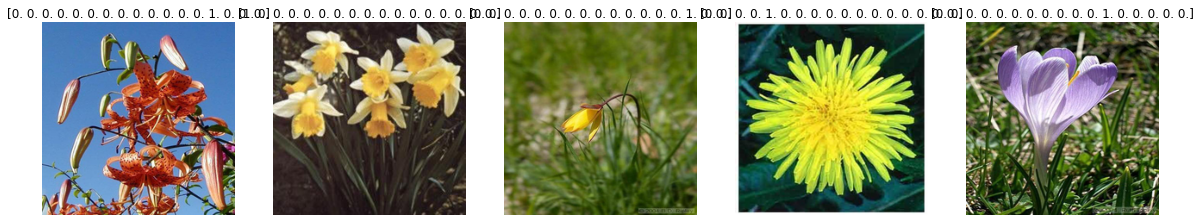

In [31]:
#2. Image Exploration & Transformation
#A. Display 5 random images
rand = np.random.randint(0, len(X), 5) # Generating 5 random numbers out of total number of flowers
print(rand)
plt.figure(figsize=(20, 20))
for i,j in enumerate(rand):
    plt.subplot(1, len(rand), i+1)
    plt.imshow(X[j])  # greens, reds, blues, rgb
    plt.title("{}".format(Y[j]))
    plt.axis('off')
plt.show()

In [32]:
#B. Select any image from the dataset and assign it to a variable. 
import random

# Original Image
img_org = random.choice(X)

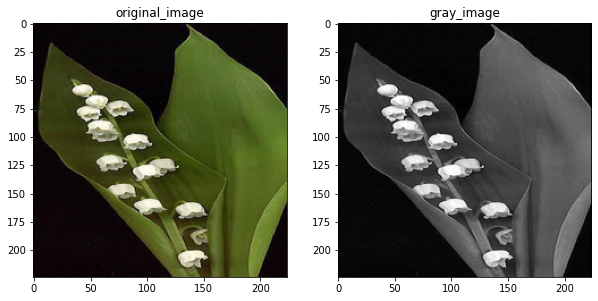

In [33]:
#C. Transform the image into grayscale format and display the same.
gray_image = cv2.cvtColor(img_org, cv2.COLOR_RGB2GRAY)

img_title = ['original_image', 'gray_image']

plt.figure(figsize=(10,10))
for i,img in enumerate([img_org, gray_image]):
    plt.subplot(1,2,i+1)
    plt.title(img_title[i])
    plt.imshow(img,cmap='gray')

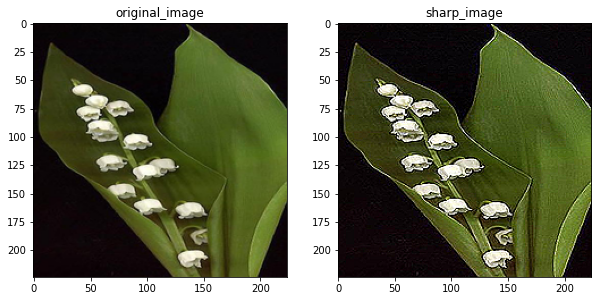

In [34]:
#D. Apply a filter to sharpen the image and display the image before and after sharpening.
sharp_filter = np.array([[0,-1,0],
                        [-1,5,-1],
                        [0,-1,0]])

sharp_img = cv2.filter2D(img_org,kernel=sharp_filter,ddepth=-1)

img_title = ['original_image',  'sharp_image']

plt.figure(figsize=(10,10))
for i,img in enumerate([img_org, sharp_img]):
    plt.subplot(1,2,i+1)
    plt.title(img_title[i])
    plt.imshow(img,cmap='gray')

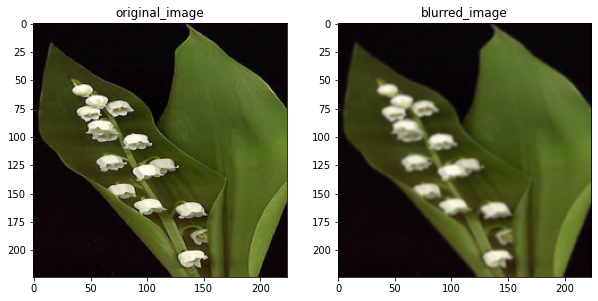

In [35]:
##E. Apply a filter to blur the image and display the image before and after blur. 
blur_img = cv2.GaussianBlur(img_org,ksize=(5,5),sigmaX=0,sigmaY=0)
img_title = ['original_image','blurred_image']

plt.figure(figsize=(10,10))
for i,img in enumerate([img_org, blur_img]):
    plt.subplot(1,2,i+1)
    plt.title(img_title[i])
    plt.imshow(img,cmap='gray')

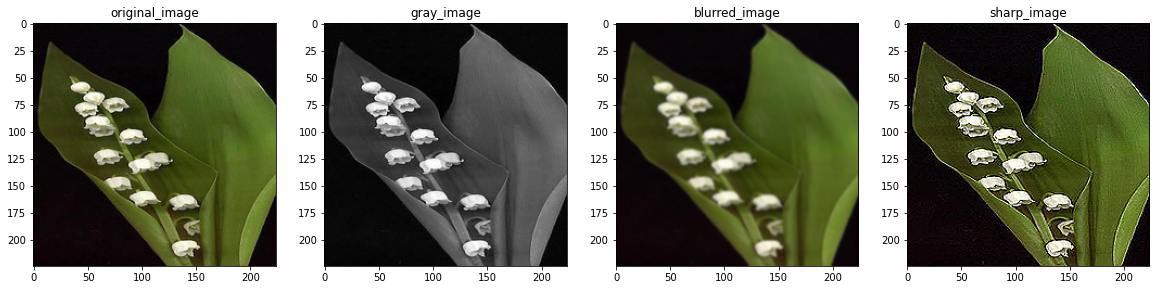

In [36]:
#F. Display all the 4 images from above questions besides each other to observe the difference.
#gray Image
gray_image = cv2.cvtColor(img_org, cv2.COLOR_RGB2GRAY)

# Blur Image
blur_img = cv2.GaussianBlur(img_org,ksize=(5,5),sigmaX=0,sigmaY=0)

# Sharp Image
sharp_filter = np.array([[0,-1,0],
                        [-1,5,-1],
                        [0,-1,0]])

sharp_img = cv2.filter2D(img_org,kernel=sharp_filter,ddepth=-1)

img_title = ['original_image', 'gray_image', 'blurred_image', 'sharp_image']

plt.figure(figsize=(20,20))
for i,img in enumerate([img_org, gray_image, blur_img, sharp_img]):
    plt.subplot(1,4,i+1)
    plt.title(img_title[i])
    plt.imshow(img,cmap='gray')

In [37]:
#3. Model training and Tuning
#A. Split the data into train and test with 80:20 proportion.

X = np.array(X)
y = np.array(Y)

print(X.shape, y.shape)

(1360, 224, 224, 3) (1360, 17)


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [39]:
#B. Train a model using any Supervised Learning algorithm and share performance metrics on test data
X_train_ml = X_train.astype('float32')
X_train_ml = X_train_ml.reshape(X_train_ml.shape[0], 150528) # 224X224X3 = 150528
X_train_ml = X_train_ml/255.0

X_test_ml = X_test.astype('float32')
X_test_ml = X_test_ml.reshape(X_test_ml.shape[0], 150528)
X_test_ml = X_test_ml/255.0

In [40]:
print('Train_Shape:', X_train_ml.shape, y_train.shape)
print('Test_Shape:', X_test_ml.shape, y_test.shape)

Train_Shape: (1088, 150528) (1088, 17)
Test_Shape: (272, 150528) (272, 17)
